# 0. Install and Import dependencies

In [95]:
# !pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

In [96]:
# Gym stuff
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
from finta import TA

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

# Processing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import quantstats as qs

In [97]:
SEED = 5756

# Specify parameters
STOCK_NAME = 'TSLA'

# Window size for training
TRAIN_WINDOW_SIZE = 10
TRAIN_START = '2020-01-01'
TRAIN_END = '2022-12-31'

TEST_WINDOW_SIZE = 10
LEARN_ITERATIONS = 50000

# Indicator parameters
SMA_PERIOD = 10

# Report output
REPORT_OUTPUT = f".\\reports\\{STOCK_NAME}_reports.html"

# 1. Get Data

In [98]:
import yfinance as yf

df = yf.Ticker(STOCK_NAME)
df = df.history(period="max")
df = df.loc[TRAIN_START:, ['Open', 'High', 'Low', 'Close', 'Volume']]
print(df.shape)
df.head()

(1082, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02 00:00:00-05:00,28.299999,28.713333,28.114000,28.684000,142981500
2020-01-03 00:00:00-05:00,29.366667,30.266666,29.128000,29.534000,266677500
2020-01-06 00:00:00-05:00,29.364668,30.104000,29.333332,30.102667,151995000
2020-01-07 00:00:00-05:00,30.760000,31.441999,30.224001,31.270666,268231500
2020-01-08 00:00:00-05:00,31.580000,33.232666,31.215334,32.809334,467164500


In [99]:
TRAIN_ENV_FRAME_BOUND = (TRAIN_WINDOW_SIZE, df[TRAIN_START:TRAIN_END].shape[0])
TEST_ENV_FRAME_BOUND = (df[TRAIN_START:TRAIN_END].shape[0] + TEST_WINDOW_SIZE, df.shape[0])

# 2.1 Add Custom Indicators

## 2.1.3. Calculate SMA, RSI and OBV

In [100]:
df['SMA'] = TA.SMA(df, SMA_PERIOD)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

## 2.1.4. Create New Environments

In [101]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [102]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

# 3. Build Environment and Train

In [103]:
env2 = MyCustomEnv(df=df, frame_bound=TRAIN_ENV_FRAME_BOUND, window_size=TRAIN_WINDOW_SIZE)
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [104]:
# model = A2C('MlpPolicy', env, verbose=0) 
# model.learn(total_timesteps=10000)

In [105]:
from sb3_contrib import RecurrentPPO
model = RecurrentPPO("MlpLstmPolicy", env, verbose=0, seed=SEED)
model.learn(total_timesteps=LEARN_ITERATIONS)

# 4. Evaluation

In [ ]:
env = MyCustomEnv(df=df, frame_bound=TEST_ENV_FRAME_BOUND, window_size=TEST_WINDOW_SIZE)
observation, info = env.reset()
while True: 
    observation = observation[np.newaxis, ...]
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

info {'total_reward': 12.68992688918263, 'total_profit': 0.5974954304344936, 'position': <Positions.Short: 0>}


In [ ]:
env.prices.max()

120.7300033569336

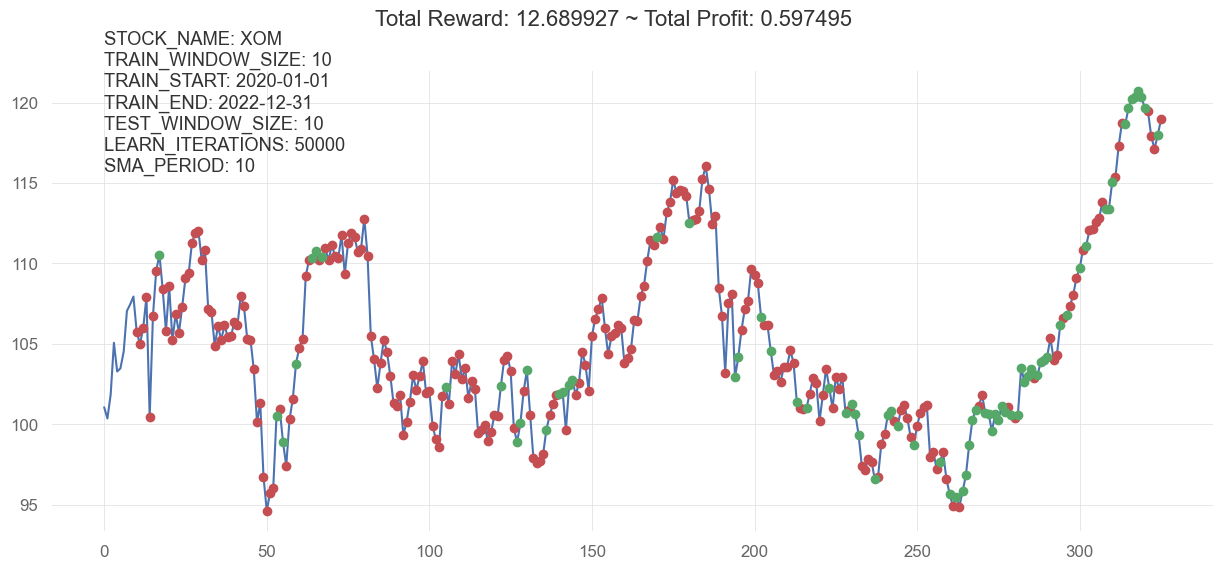

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.text(0, env.prices.max() - 5, 
    f'STOCK_NAME: {STOCK_NAME}\nTRAIN_WINDOW_SIZE: {TRAIN_WINDOW_SIZE}\nTRAIN_START: {TRAIN_START}\nTRAIN_END: {TRAIN_END}\nTEST_WINDOW_SIZE: {TEST_WINDOW_SIZE}\nLEARN_ITERATIONS: {LEARN_ITERATIONS}\nSMA_PERIOD: {SMA_PERIOD}'
)
plt.savefig(f'.\\reports\\{STOCK_NAME}_trade_strategy.png')
plt.show()

# 5. QuantStats

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

                           Strategy
-------------------------  ----------
Start Period               2023-01-20
End Period                 2024-04-19
Risk-Free Rate             0.0%
Time in Market             14.0%

Cumulative Return          -40.25%
CAGR﹪                     -24.82%

Sharpe                     -3.58
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -3.4
Sortino                    -3.75
Smart Sortino              -3.56
Sortino/√2                 -2.65
Smart Sortino/√2           -2.52
Omega                      0.15

Max Drawdown               -40.25%
Longest DD Days            446
Volatility (ann.)          11.35%
Calmar                     -0.62
Skew                       -2.79
Kurtosis                   19.01

Expected Daily %           -0.16%
Expected Monthly %         -3.17%
Expected Yearly %          -22.7%
Kelly Criterion            -96.7%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.34%
Expected Shortfall (cVaR)  -1.34%

Max Consecutive

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-01-30,2024-04-19,2024-04-19,445,-40.250457,-39.475286


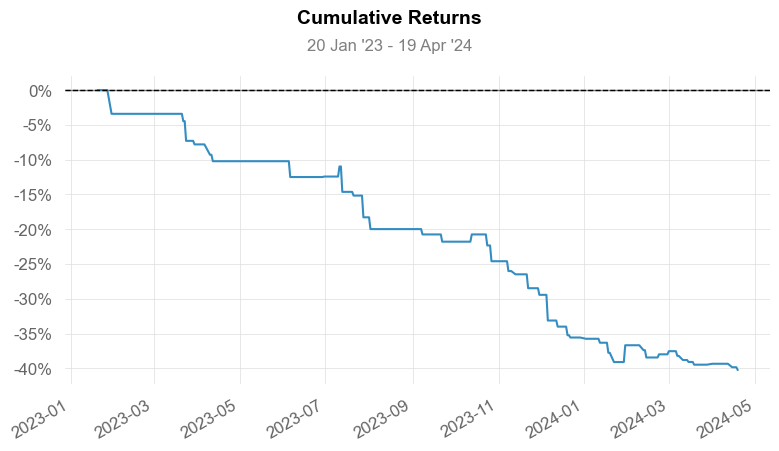

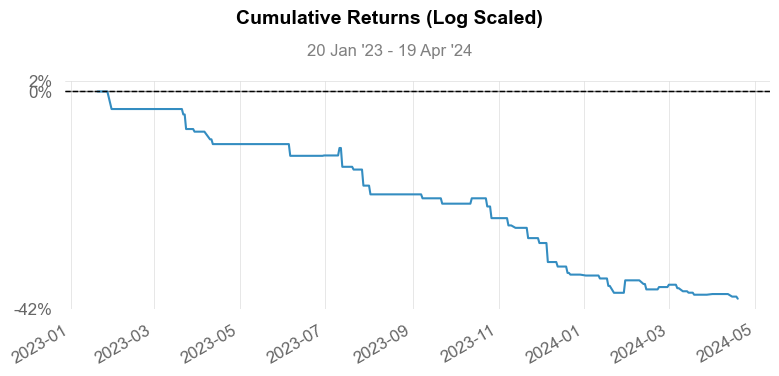

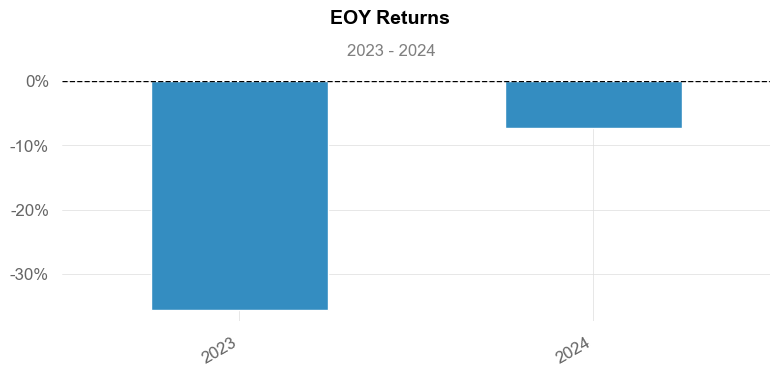

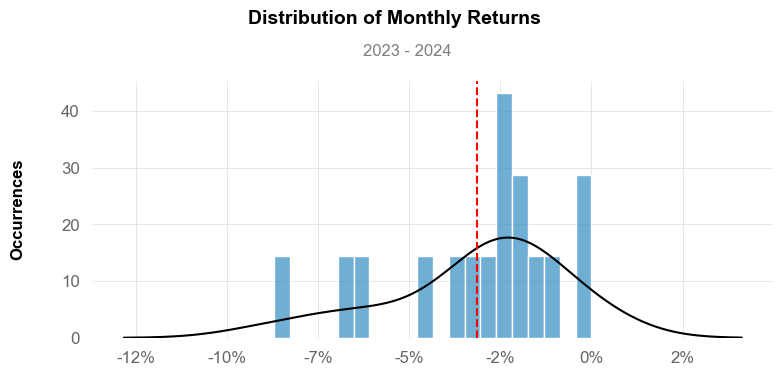

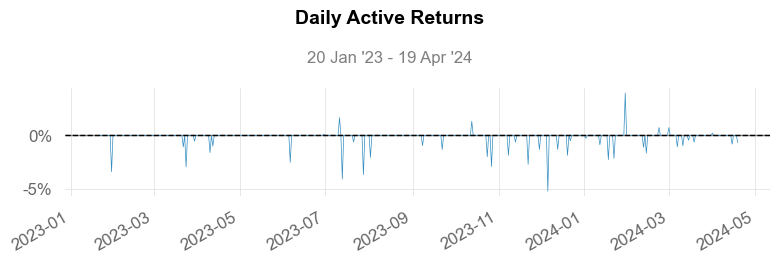

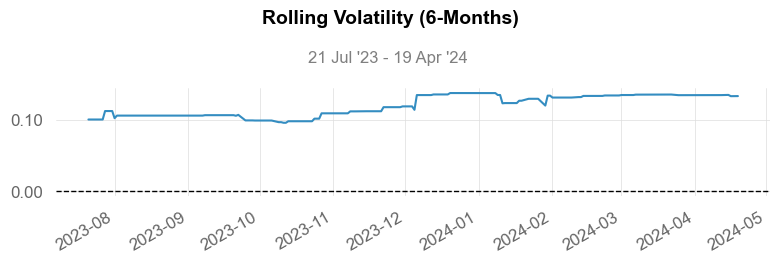

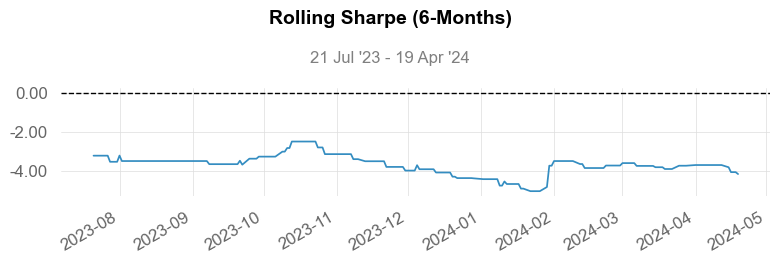

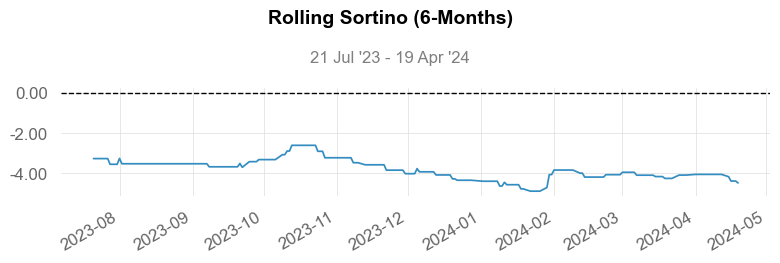

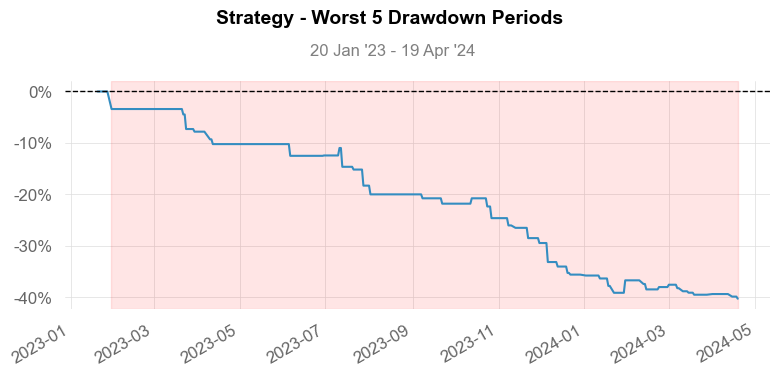

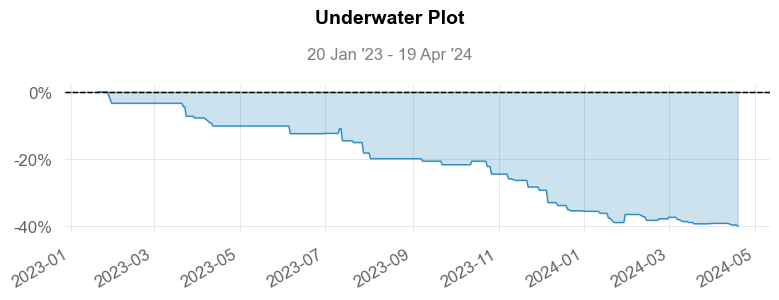

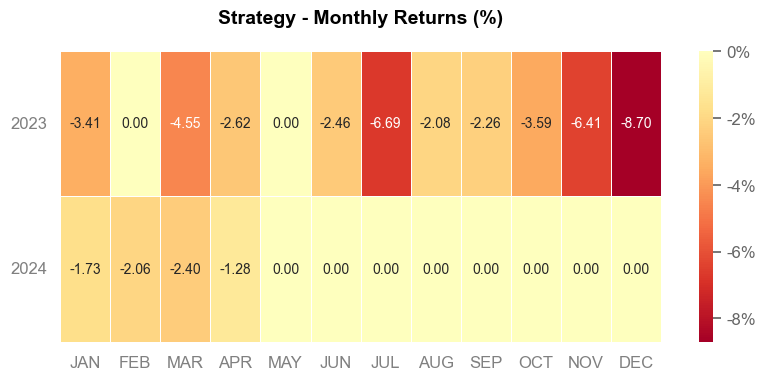

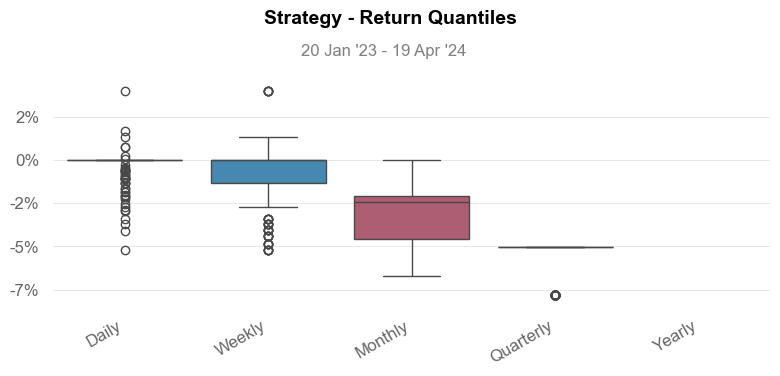

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

In [ ]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[TEST_ENV_FRAME_BOUND[0] + 1:TEST_ENV_FRAME_BOUND[1]])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output=REPORT_OUTPUT)